## Import data and QC

In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

In [2]:
import os
import pandas as pd
import numpy  as np
import seaborn as sns
import matplotlib.pyplot as plt
import anndata as ad

now_path=os.getcwd()
data_path=now_path+'\\..\\raw data\\'
file='K562_essential_normalized_bulk_01.h5ad'
file2='K562_gwps_normalized_bulk_01.h5ad'
file3='rpe1_normalized_bulk_01.h5ad'


K_e_n_b_adata=ad.read_h5ad(data_path+file)
K_g_n_b_adata=ad.read_h5ad(data_path+file2)
rpe1_adata=ad.read_h5ad(data_path+file3)

In [3]:
K_e_n_b_adata

AnnData object with n_obs × n_vars = 2285 × 8563
    obs: 'UMI_count_unfiltered', 'num_cells_unfiltered', 'num_cells_filtered', 'control_expr', 'fold_expr', 'pct_expr', 'core_control', 'mean_leverage_score', 'std_leverage_score', 'energy_test_p_value', 'anderson_darling_counts', 'mann_whitney_counts', 'z_gemgroup_UMI', 'mitopercent', 'TE_ratio', 'cnv_score_z'
    var: 'gene_name', 'mean', 'std', 'cv', 'in_matrix', 'gini', 'clean_mean', 'clean_std', 'clean_cv'

In [4]:
def extract_gene_name_from_index(index_str):
    parts = index_str.split('_')
    if len(parts) >= 2:
        return parts[1] 
    else:
        return index_str

K_e_n_b_adata.obs['target']=[extract_gene_name_from_index(idx) for idx in K_e_n_b_adata.obs.index]
K_g_n_b_adata.obs['target']=[extract_gene_name_from_index(idx) for idx in K_g_n_b_adata.obs.index]
rpe1_adata.obs['target']=[extract_gene_name_from_index(idx) for idx in rpe1_adata.obs.index]

### Select on-target and strong/weak perturbation

In [5]:
mask_strong=(K_g_n_b_adata.obs['anderson_darling_counts']>=50) & ( K_g_n_b_adata.obs['target']!='non-targeting') & (K_g_n_b_adata.obs['pct_expr']<=-0.3) 
strong_gwp=K_g_n_b_adata[mask_strong]

mask_weak=(K_g_n_b_adata.obs['anderson_darling_counts']<5) & ( K_g_n_b_adata.obs['target']!='non-targeting') & (K_g_n_b_adata.obs['pct_expr']<=-0.3) 
weak_gwp=K_g_n_b_adata[mask_weak]

mask_on_target=( K_g_n_b_adata.obs['target']!='non-targeting')& (K_g_n_b_adata.obs['pct_expr']<=-0.3) 
on_target_gwp=K_g_n_b_adata[mask_on_target]

mask_control=( K_g_n_b_adata.obs['target']=='non-targeting')
on_target_ess=K_g_n_b_adata[mask_control]

obs=K_g_n_b_adata.obs
obs['class']='off_target'
obs.loc[mask_strong, 'class']='strong'
obs.loc[mask_weak, 'class']='weak'
obs.loc[mask_control, 'class']='control'

In [6]:
print(strong_gwp.shape)
print(weak_gwp.shape)
print(on_target_gwp.shape)

(1966, 8248)
(5746, 8248)
(9450, 8248)


In [7]:
mask_strong=(K_e_n_b_adata.obs['anderson_darling_counts']>=50) & ( K_e_n_b_adata.obs['target']!='non-targeting')& (K_e_n_b_adata.obs['pct_expr']<=-0.3) 
strong_ess=K_e_n_b_adata[mask_strong]

mask_weak=(K_e_n_b_adata.obs['anderson_darling_counts']<5) & ( K_e_n_b_adata.obs['target']!='non-targeting')& (K_e_n_b_adata.obs['pct_expr']<=-0.3) 
weak_ess=K_e_n_b_adata[mask_weak]

mask_on_target=( K_e_n_b_adata.obs['target']!='non-targeting')& (K_e_n_b_adata.obs['pct_expr']<=-0.3) 
on_target_ess=K_e_n_b_adata[mask_on_target]

mask_control=( K_e_n_b_adata.obs['target']=='non-targeting')
on_target_ess=K_e_n_b_adata[mask_control]

obs=K_e_n_b_adata.obs
obs['class']='off_target'
obs.loc[mask_strong, 'class']='strong'
obs.loc[mask_weak, 'class']='weak'
obs.loc[mask_control, 'class']='control'

In [8]:
print(strong_ess.shape)
print(weak_ess.shape)
print(on_target_ess.shape)

(1116, 8563)
(520, 8563)
(109, 8563)


#### plot fig S2

##### fig S2-G

In [9]:
a=K_e_n_b_adata.obs[['class']].copy()
a['dataset']='essential'

b=K_g_n_b_adata.obs[['class']].copy()
b['dataset']='gwps'

In [10]:
df_all = pd.concat([a, b], ignore_index=True)
category_order = ['strong', 'weak', 'control']


df_all['class'] = pd.Categorical(df_all['class'],
                                     categories=category_order,
                                     ordered=True)

stack_order = [ 'gwps','essential'] 
df_all['dataset'] = pd.Categorical(df_all['dataset'],
                                     categories=stack_order,
                                     ordered=True)

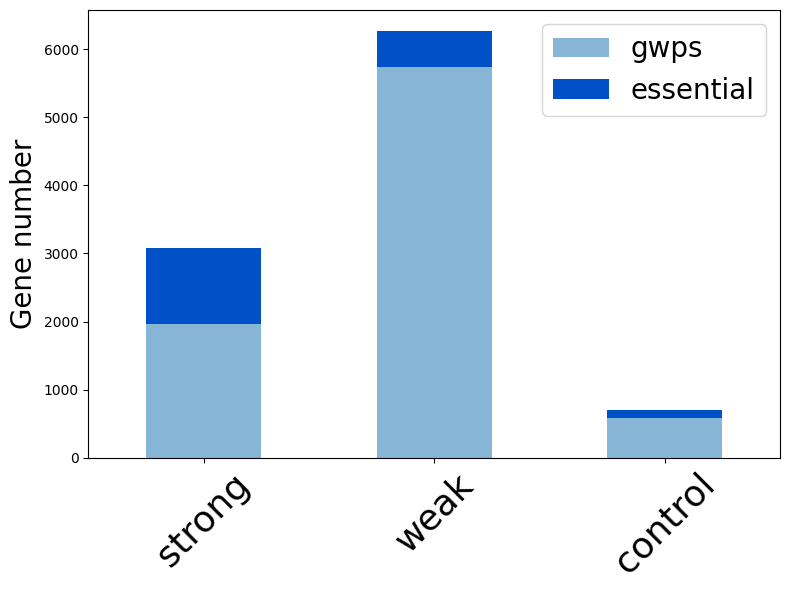

In [ ]:
x=pd.crosstab(df_all['class'],df_all['dataset'])

colors = ["#1f76b48a", "#0050c8"]  
ax = x.plot(kind='bar', stacked=True, figsize=(8,6), color=colors)

ax.set_xlabel('', fontsize=12)
ax.set_ylabel('Gene number', fontsize=20)

plt.xticks(rotation=45,fontsize=26)
plt.legend(fontsize=20)
plt.tight_layout()
plt.show()

##### fig S2-F

In [12]:
strong_genes_flat=strong_gwp.obs['target'].to_list()
weak_genes_flat=weak_gwp.obs['target'].to_list()

In [13]:
import gseapy as gp
enr_strong = gp.enrichr(
    gene_list=strong_genes_flat,
    gene_sets='KEGG_2021_Human',
    organism='Human',
    outdir=None
)


In [14]:
enr_weak = gp.enrichr(
    gene_list=weak_genes_flat,
    gene_sets='KEGG_2021_Human',
    organism='Human',
    outdir=None
)

In [15]:
enr_strong.results

Gene_set                                     Term  Overlap  \
0    KEGG_2021_Human                                 Ribosome  114/158   
1    KEGG_2021_Human                            RNA transport   84/186   
2    KEGG_2021_Human        Ribosome biogenesis in eukaryotes   55/108   
3    KEGG_2021_Human                              Spliceosome   63/150   
4    KEGG_2021_Human                      Coronavirus disease   77/232   
..               ...                                      ...      ...   
282  KEGG_2021_Human                   Olfactory transduction    1/440   
283  KEGG_2021_Human  Neuroactive ligand-receptor interaction    1/341   
284  KEGG_2021_Human   Cytokine-cytokine receptor interaction    1/295   
285  KEGG_2021_Human             Systemic lupus erythematosus    1/135   
286  KEGG_2021_Human                Calcium signaling pathway    4/240   

          P-value  Adjusted P-value  Old P-value  Old Adjusted P-value  \
0    2.207187e-79      6.334627e-77            0                     0   
1    4.453504e-36      6.390778e-34            0                     0   
2    2.341015e-27      2.239571e-25            0                     0   
3    3.194356e-25      2.291950e-23            0                     0   
4    8.691399e-23      4.988863e-21            0                     0   
..            ...               ...          ...                   ...   
282  9.999948e-01      9.999956e-01            0                     0   
283  9.999951e-01      9.999956e-01            0                     0   
284  9.999954e-01      9.999956e-01            0                     0   
285  9.999956e-01      9.999956e-01            0                     0   
286  9.999956e-01      9.999956e-01            0                     0   

     Odds Ratio  Combined Score  \
0     25.212670    4.566330e+03   
1      7.860564    6.398450e+02   
2      9.781259    5.997791e+02   
3      6.841198    3.858657e+02   
4      4.710136    2.392613e+02   
..          ...             ...   
282    0.020431    1.069759e-07   
283    0.026529    1.288251e-07   
284    0.030760    1.429030e-07   
285    0.068096    3.010445e-07   
286    0.154013    6.782123e-07   

                                                 Genes  
0    RPL4;RPL5;RPL30;RPL32;RPL31;RPL34;RPL10A;RPL8;...  
1    EIF4A1;POP5;POP7;NXT1;NUP188;POP1;POP4;RPP30;P...  
2    POP5;RBM28;POP7;NXT1;POP1;NVL;POP4;RPP30;WDR3;...  
3    TCERG1;RBM25;DDX46;HNRNPU;PRPF19;USP39;PQBP1;S...  
4    RPL4;RPL5;RPL30;RPL32;RPL31;RPL34;RPLP1;RPLP0;...  
..                                                 ...  
282                                              ARRB2  
283                                             CHRNB1  
284                                            TNFSF10  
285                                             SNRPD3  
286                              PPP3CB;ASPH;PRKCA;MCU  

[287 rows x 10 columns]

In [16]:
top20_strong = enr_strong.results.sort_values('Adjusted P-value').head(20)
top20_weak = enr_weak.results.sort_values('Adjusted P-value').head(20)
top20_strong['-log10(adjusted P)']=-np.log10(top20_strong['Adjusted P-value'])
top20_weak['-log10(adjusted P)']=-np.log10(top20_weak['Adjusted P-value'])

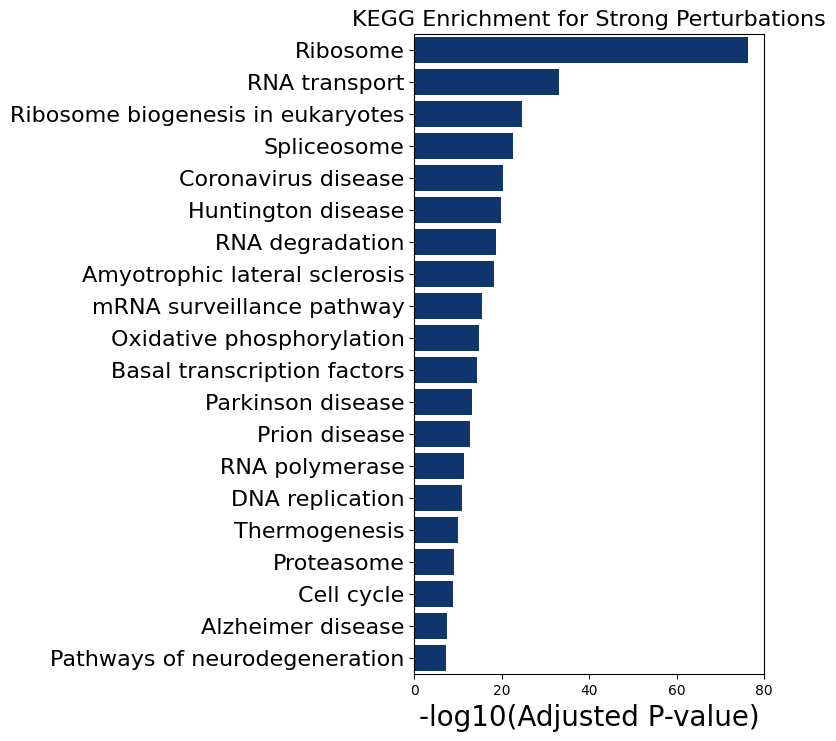

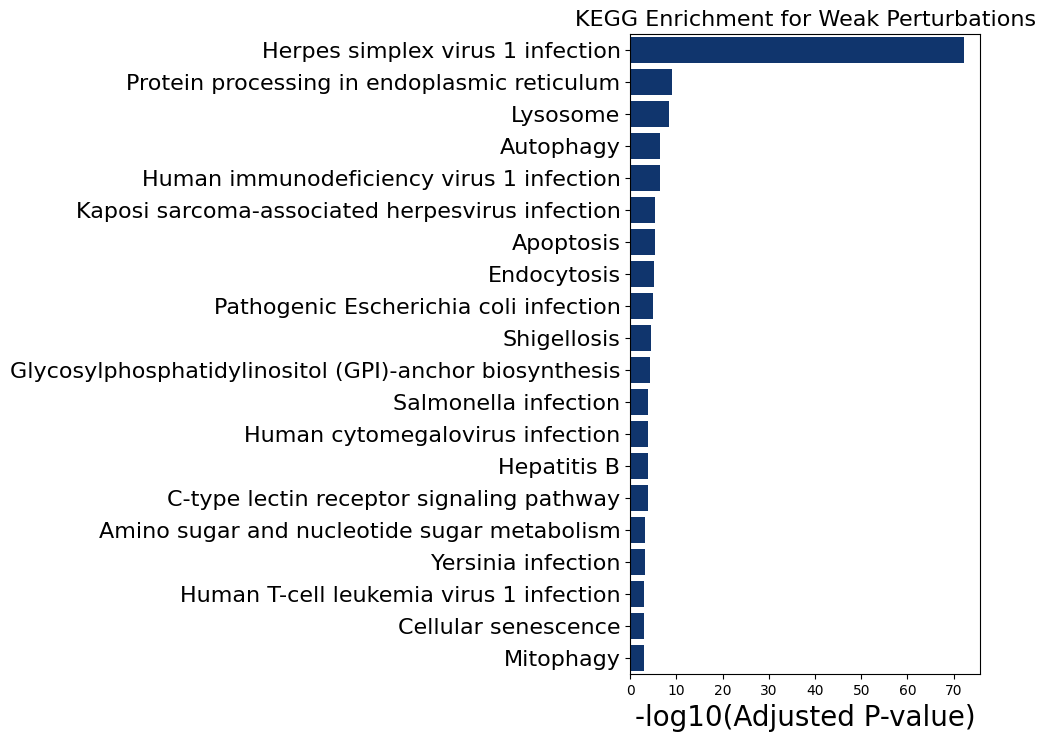

In [22]:
plt.figure(figsize=(10,8))
sns.barplot(
    data=top20_strong,
    y='Term',
    x='-log10(adjusted P)',
    color="#00327D",
    dodge=True
)
plt.xlabel('-log10(Adjusted P-value)',fontsize=20)
plt.yticks(fontsize=16)  
plt.title('KEGG Enrichment for Strong Perturbations',fontsize=16)
plt.tight_layout()
plt.ylabel('')
plt.subplots_adjust(left=0.6, right=0.95, top=0.9, bottom=0.1)  
plt.show()

plt.figure(figsize=(10,8))
sns.barplot(
    data=top20_weak,
    y='Term',
    x='-log10(adjusted P)',
    color="#00327D",
    dodge=True
)
plt.xlabel('-log10(Adjusted P-value)',fontsize=20)
plt.yticks(fontsize=16)  
plt.title('KEGG Enrichment for Weak Perturbations',fontsize=16)
plt.tight_layout()
plt.ylabel('')
plt.subplots_adjust(left=0.6, right=0.95, top=0.9, bottom=0.1)  
plt.show()

##### fig S2-I

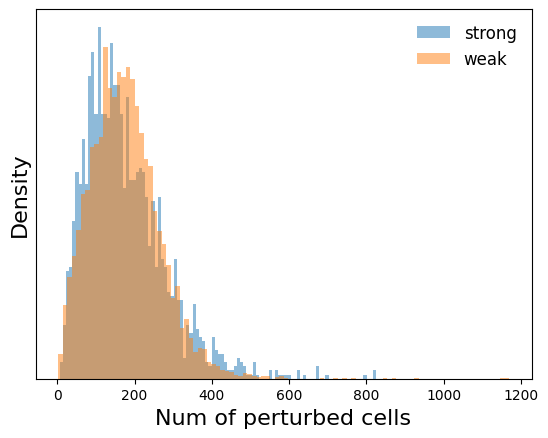

In [19]:
a=strong_gwp.obs['num_cells_filtered']
b=weak_gwp.obs['num_cells_filtered']

plt.hist(a, bins=100,alpha=0.5,density=True,label='strong')
plt.hist(b, bins=100,alpha=0.5,density=True,label='weak')
plt.xlabel("Num of perturbed cells",fontsize=16)
plt.ylabel("Density",fontsize=16)
plt.yticks([])
plt.legend(fontsize=12,frameon=False)
plt.show()


##### fig S2-J

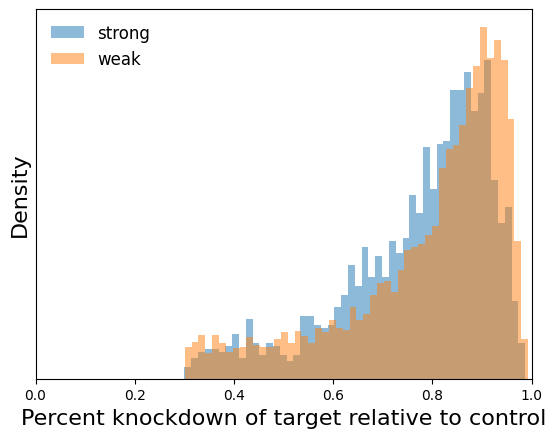

In [21]:
a=-strong_gwp.obs['pct_expr'][strong_gwp.obs['pct_expr']!=-1]
b=-weak_gwp.obs['pct_expr'][weak_gwp.obs['pct_expr']!=-1]
import matplotlib.pyplot as plt

plt.hist(a, bins=50,alpha=0.5,density=True,label='strong')
plt.hist(b, bins=50,alpha=0.5,density=True,label='weak')
plt.xlabel("Percent knockdown of target relative to control",fontsize=16)
plt.xlim(0,1)
plt.ylabel("Density",fontsize=16)
plt.yticks([])
plt.legend(fontsize=12,frameon=False)
plt.show()

## Defining gene function with Perturb-seq

### select high-variable genes

In [23]:
top_hvg_genes = strong_gwp.var['clean_mean']>0.25
strong_gwp_hvg = strong_gwp[:, top_hvg_genes].copy()

top_hvg_genes=strong_gwp_hvg.var['cv'].sort_values(ascending=False).head(2319).index
strong_gwp_hvg = strong_gwp_hvg[:, top_hvg_genes].copy()

In [24]:
strong_gwp_hvg.var

gene_name      mean       std        cv  in_matrix      gini  \
gene_id                                                                         
ENSG00000197989     SNHG12  0.373688  0.278096  0.744192       True  0.115514   
ENSG00000268621  IGFL2-AS1  0.272827  0.175933  0.644852       True  0.218122   
ENSG00000158578      ALAS2  0.275822  0.176217  0.638881       True  0.255912   
ENSG00000016490      CLCA1  0.424085  0.251083  0.592058       True  0.255891   
ENSG00000137331       IER3  0.264056  0.153519  0.581389       True  0.246693   
...                    ...       ...       ...       ...        ...       ...   
ENSG00000083937     CHMP2B  0.433876  0.068845  0.158675       True  0.084940   
ENSG00000145293     ENOPH1  0.484700  0.076908  0.158670       True  0.084863   
ENSG00000101150    TPD52L2  0.446464  0.070834  0.158656       True  0.085031   
ENSG00000162441       LZIC  0.547936  0.086922  0.158635       True  0.083375   
ENSG00000156831     NSMCE2  0.431344  0.068423  0.158627       True  0.085787   

                 clean_mean  clean_std  clean_cv  
gene_id                                           
ENSG00000197989    0.381178   0.289604  0.759759  
ENSG00000268621    0.280068   0.183161  0.653986  
ENSG00000158578    0.283753   0.184098  0.648797  
ENSG00000016490    0.435241   0.261241  0.600223  
ENSG00000137331    0.265348   0.157773  0.594588  
...                     ...        ...       ...  
ENSG00000083937    0.445890   0.070824  0.158837  
ENSG00000145293    0.498137   0.078361  0.157309  
ENSG00000101150    0.458476   0.072626  0.158407  
ENSG00000162441    0.563032   0.089840  0.159564  
ENSG00000156831    0.443101   0.070315  0.158688  

[2319 rows x 9 columns]

#### plot fig 2-A

In [25]:
import scanpy as sc
import seaborn as sns

strong_gwp_hvg_array=strong_gwp_hvg.X
strong_gwp_hvg_array[~np.isfinite(strong_gwp_hvg_array)] = 0
strong_gwp_hvg.X=strong_gwp_hvg_array

strong_gwp_hvg_df=strong_gwp_hvg.to_df()
strong_gwp_hvg_df.index=strong_gwp_hvg.obs['target']
strong_gwp_hvg_df.columns=strong_gwp_hvg.var['gene_name']

d:\software\Anaconda\envs\licheng\lib\site-packages\seaborn\matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
d:\software\Anaconda\envs\licheng\lib\site-packages\seaborn\matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


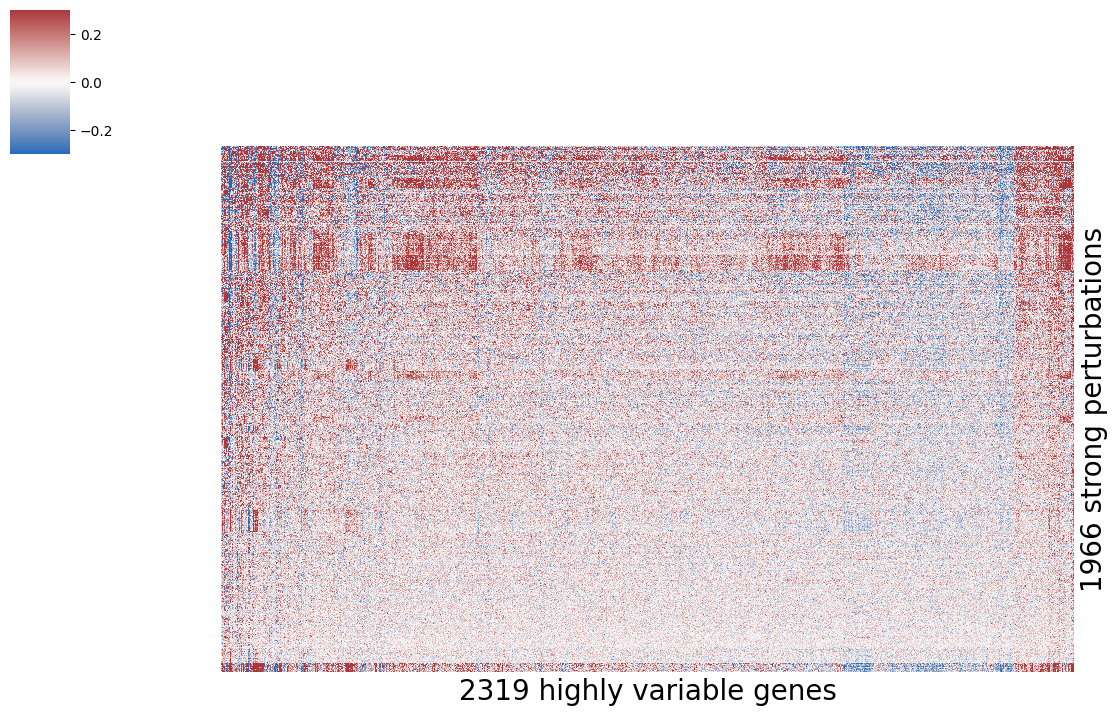

In [26]:
cg=sns.clustermap(strong_gwp_hvg_df,
                  vmin=-0.3,
                  vmax=0.3,
                  center=0,
                  cmap='vlag',figsize=(12,8),
                 
    )
cg.ax_heatmap.set_xticks([])
cg.ax_heatmap.set_yticks([])
cg.ax_heatmap.set_xlabel('2319 highly variable genes',fontsize=20)
cg.ax_heatmap.set_ylabel('1966 strong perturbations',fontsize=20)

cg.ax_row_dendrogram.set_visible(False)
cg.ax_col_dendrogram.set_visible(False)

### correlation matrix between strong perturbations

In [27]:
strong_gwp_df=strong_gwp.to_df()
strong_gwp_df.index=strong_gwp.obs['target']
strong_gwp_df.columns=strong_gwp.var['gene_name']
correlation_matrix = strong_gwp_hvg_df.T.corr(method='pearson')

#### plot fig 2-A

d:\software\Anaconda\envs\licheng\lib\site-packages\seaborn\matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
d:\software\Anaconda\envs\licheng\lib\site-packages\seaborn\matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


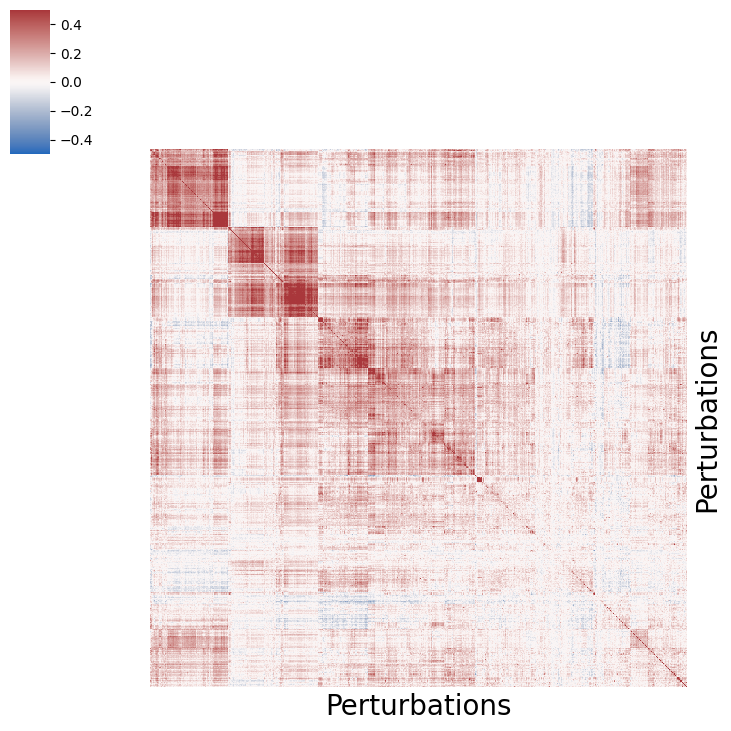

In [28]:
cg=sns.clustermap(correlation_matrix,
                  vmin=-0.5,
                  vmax=0.5,
                  center=0,
                  cmap='vlag',figsize=(8,8),
                  
    )
cg.ax_heatmap.set_xticks([])
cg.ax_heatmap.set_yticks([])
cg.ax_heatmap.set_xlabel('Perturbations',fontsize=20)
cg.ax_heatmap.set_ylabel('Perturbations',fontsize=20)

cg.ax_row_dendrogram.set_visible(False)
cg.ax_col_dendrogram.set_visible(False)

### Use CORUM dataset to check the correlation in protein complex

In [29]:
import json
with open(f'{data_path}coreComplexes.json', "r", encoding="utf-8") as f:
    corum_data = json.load(f)

corum_list=[]
for i in corum_data:
    corum_list.append(i['subunits(Gene name)'])

strong_genes_list=correlation_matrix.index.to_list()

In [30]:
corum_list_intersect=[]
for gene_string in corum_list:
    genes=gene_string.split(';')
    N=len(genes)
    n=0
    for gene in genes:
        if gene in strong_genes_list:
            n+=1
    if n/N>0.66:
        corum_list_intersect.append(genes)

In [31]:
correlation_value=correlation_matrix.values
correlation_list_all = correlation_value[np.triu_indices_from(correlation_value, k=1)]

ppi_pairs=[]
for gene_pairs in corum_list_intersect:
    for i,gene1 in enumerate(gene_pairs):
        for gene2 in gene_pairs[i+1:]:
            if gene1 in strong_genes_list and gene2 in strong_genes_list:
                pair=set(frozenset((gene1, gene2)))
                ppi_pairs.append(pair)

len(ppi_pairs)

14690

In [32]:
mask_ppi = np.zeros_like(correlation_matrix, dtype=bool)
gene2idx={g:i for i,g in enumerate(strong_genes_list)}

for p1,p2 in ppi_pairs:
    i=gene2idx[p1]
    j=gene2idx[p2]
    if i<j:
        mask_ppi[i,j]=1
    else:
        mask_ppi[j,i]=1

correlation_list_corum=correlation_value[mask_ppi]

#### plot fig 2-B

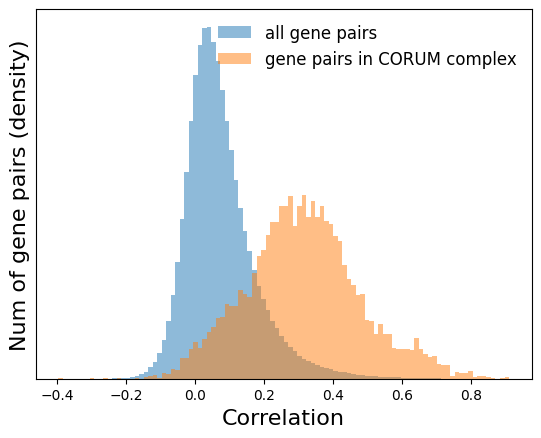

In [ ]:
plt.hist(correlation_list_all, bins=100,alpha=0.5,density=True,label='all gene pairs')
plt.hist(correlation_list_corum, bins=100,alpha=0.5,density=True,label='gene pairs in CORUM complex')
plt.xlabel("Correlation",fontsize=16)
plt.ylabel("Num of gene pairs (density)",fontsize=16)
plt.yticks([])
plt.legend(fontsize=12,frameon=False)
plt.show()

In [41]:
np.median(correlation_list_all)

np.float64(0.057142962057401075)

In [42]:
np.median(correlation_list_corum)

np.float64(0.30911872662827977)

### Clustering and visualize

#### use HDBSCAN to clustering

In [36]:
distance = (2*(1 - correlation_matrix))**0.5
from sklearn.cluster import HDBSCAN
cluster=HDBSCAN(
    metric='precomputed',
    min_cluster_size=3,
    min_samples=1,
    cluster_selection_method='eom'
)
cluster.fit_predict(distance)

array([-1, -1,  5, ..., 12, -1, -1], shape=(1966,))

In [37]:
labels=cluster.labels_
np.unique_counts(labels)

UniqueCountsResult(values=array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
       16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32,
       33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49,
       50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61]), counts=array([1416,    3,    3,    4,    3,    4,    6,    3,    3,    4,    4,
          6,    7,    3,    6,    4,    3,    3,    3,    3,   17,    5,
          6,    3,    3,    5,    3,   12,    5,    7,    4,    7,    4,
          5,    6,    4,    3,    4,    3,    5,    6,    8,    8,    3,
          4,    6,    5,    4,    8,    3,    6,    4,    3,  108,    8,
         10,   20,    4,   38,   56,    3,    8,   41]))

#### plot fig 2-C

In [38]:
import pymde

embedding_2d = pymde.preserve_neighbors(
    correlation_matrix.values,
    embedding_dim=2,
    n_neighbors=7,
    repulsive_fraction=5,
    init='random'
)

embedding_2d = embedding_2d.embed()


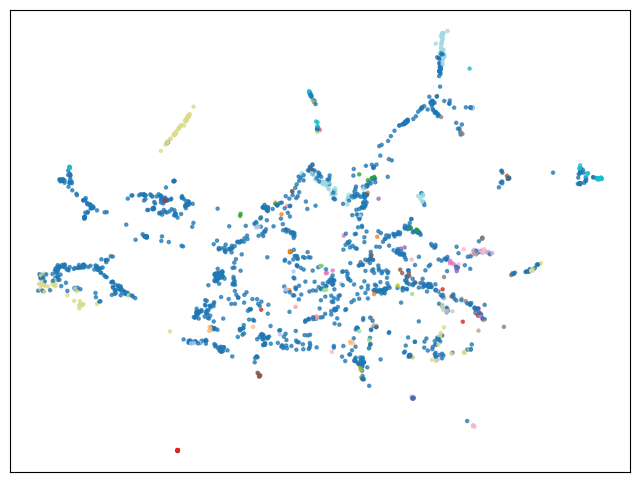

In [40]:

coords_2d=embedding_2d


plt.figure(figsize=(8, 6))
scatter = plt.scatter(
    coords_2d[:,0],
    coords_2d[:,1],
    c=labels,        
    cmap="tab20",
    s=5,
    alpha=0.7
)
plt.xticks([])
plt.yticks([])
plt.show()

## compared the similarity of transcriptional phenotypes between all three Perturb-seq datasets.

### correlation between perturbations across datasets

In [43]:
mask=( rpe1_adata.obs['target']!='non-targeting') & (rpe1_adata.obs['pct_expr']<=-0.3) 
rpe1_on_target=rpe1_adata[mask]
mask=( K_e_n_b_adata.obs['target']!='non-targeting') & (K_e_n_b_adata.obs['pct_expr']<=-0.3) 
K562_ess_on_target=K_e_n_b_adata[mask]
mask=( K_g_n_b_adata.obs['target']!='non-targeting') & (K_g_n_b_adata.obs['pct_expr']<=-0.3) 
K562_gwp_on_target=K_g_n_b_adata[mask]


In [44]:
gene_ess=K562_ess_on_target.obs.index.to_numpy()
gene_gwp=K562_gwp_on_target.obs.index.to_numpy()
gene_rpe=rpe1_on_target.obs.index.to_numpy()
gene_ess_gwp_common=np.intersect1d(gene_ess,gene_gwp)
gene_ess_rpe_common=np.intersect1d(gene_ess,gene_rpe)

print(len(gene_ess_gwp_common),len(gene_ess_rpe_common))

1903 1945


#### plot fig S4-A (the correlation between K562 gwps and essential)

In [45]:
correlation_matrix_K562_list=[]

adatas=[K562_ess_on_target[gene_ess_gwp_common.tolist(),:],K562_gwp_on_target[gene_ess_gwp_common.tolist(),:]]

for adata in adatas:

    top_hvg_genes = adata.var['clean_mean']>0.25
    adata_hvg = adata[:, top_hvg_genes]
    top_hvg_genes=adata_hvg.var['cv'].sort_values(ascending=False).head(2319).index
    adata_hvg = adata_hvg[:, top_hvg_genes]

    adata_hvg_df=adata_hvg.to_df()
    adata_hvg_df.index=adata_hvg.obs['target']
    adata_hvg_df.columns=adata_hvg.var['gene_name']

    correlation_matrix_i = adata_hvg_df.T.corr(method='pearson')

    correlation_matrix_K562_list.append(correlation_matrix_i)

In [46]:
correlation_value_1=correlation_matrix_K562_list[0].values
correlation_list_1 = correlation_value_1[np.triu_indices_from(correlation_value_1, k=1)]

correlation_value_2=correlation_matrix_K562_list[1].values
correlation_list_2 = correlation_value_2[np.triu_indices_from(correlation_value_2, k=1)]

Text(0.5, 1.0, 'correlation between perturbations')

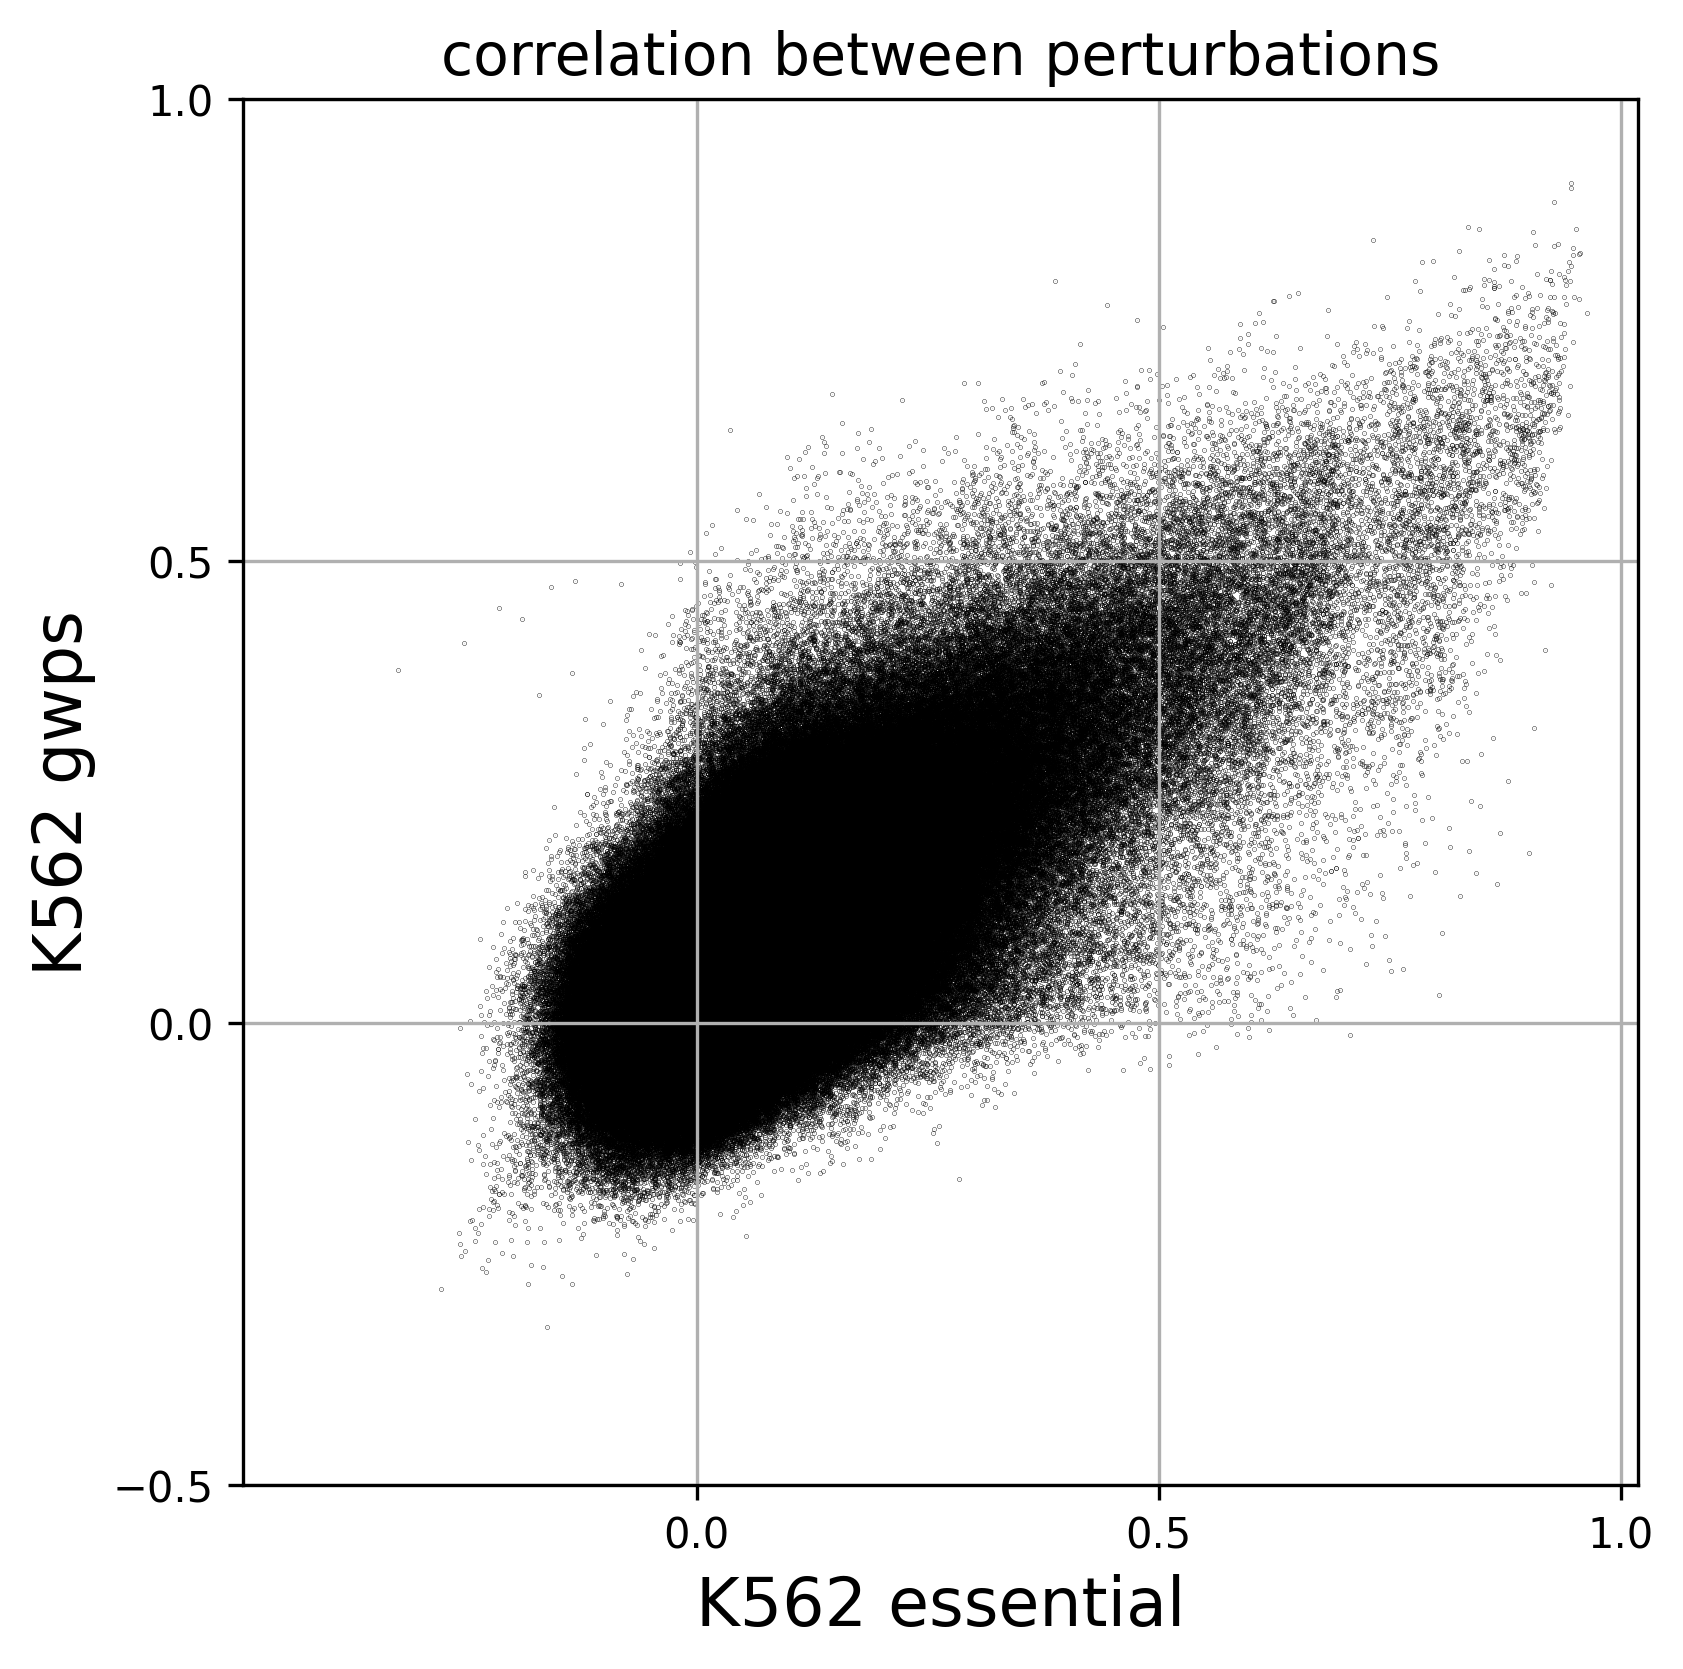

In [47]:
import matplotlib.pyplot as plt
plt.figure(figsize=(6,6),dpi=300)
plt.scatter(correlation_list_1,
            correlation_list_2,
            s=0.01,
            color='black',
)
plt.xlim(-0.5,1)
plt.ylim(-0.5,1)
plt.axis('equal')
plt.grid(True)
plt.xlabel("K562 essential",fontsize=16)
plt.ylabel("K562 gwps",fontsize=16)
plt.xticks([-0.5,0,0.5,1])
plt.yticks([-0.5,0,0.5,1])
plt.title("correlation between perturbations",fontsize=14)

In [ ]:
np.corrcoef(correlation_list_1, correlation_list_2)[0,1]

np.float64(0.6847241447746606)

#### plot fig S4-C (the correlation between K562 essential and rpe1 essential)

In [52]:
correlation_matrix_K562_rpe1_list=[]

adatas=[K562_ess_on_target[gene_ess_rpe_common.tolist(),:],rpe1_on_target[gene_ess_rpe_common.tolist(),:]]

for adata in adatas:

    top_hvg_genes = adata.var['clean_mean']>0.25
    adata_hvg = adata[:, top_hvg_genes]
    top_hvg_genes=adata_hvg.var['cv'].sort_values(ascending=False).head(2319).index
    adata_hvg = adata_hvg[:, top_hvg_genes]

    adata_hvg_df=adata_hvg.to_df()
    adata_hvg_df.index=adata_hvg.obs['target']
    adata_hvg_df.columns=adata_hvg.var['gene_name']

    correlation_matrix_i = adata_hvg_df.T.corr(method='pearson')

    correlation_matrix_K562_rpe1_list.append(correlation_matrix_i)

In [53]:
correlation_value_1=correlation_matrix_K562_rpe1_list[0].values
correlation_list_1 = correlation_value_1[np.triu_indices_from(correlation_value_1, k=1)]

correlation_value_2=correlation_matrix_K562_rpe1_list[1].values
correlation_list_2 = correlation_value_2[np.triu_indices_from(correlation_value_2, k=1)]

Text(0.5, 1.0, 'correlation between perturbations')

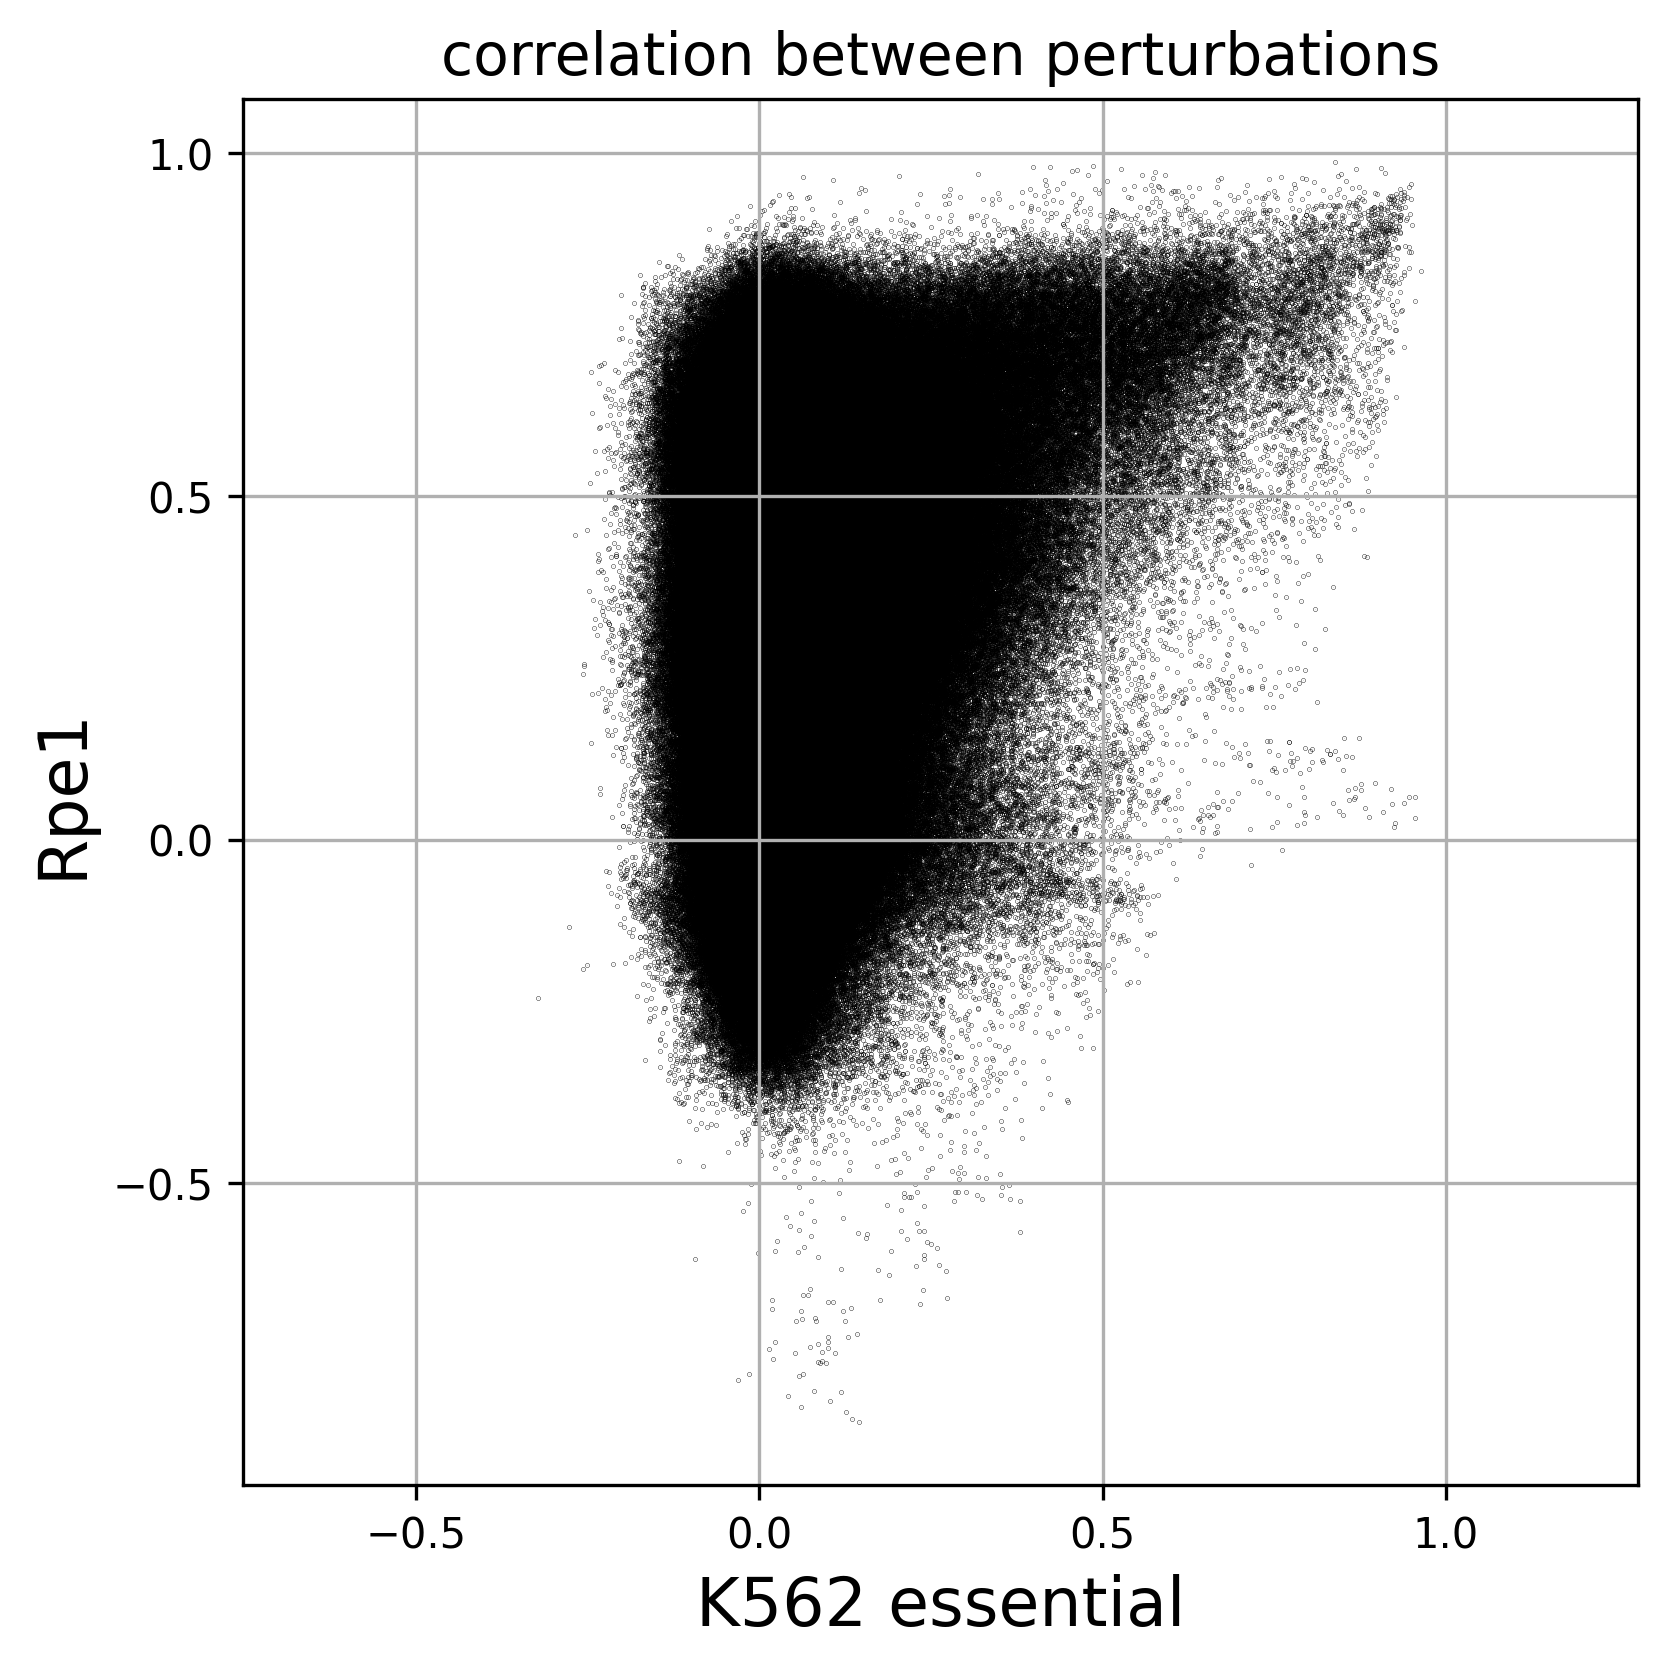

In [58]:
import matplotlib.pyplot as plt
plt.figure(figsize=(6,6),dpi=300)
plt.scatter(correlation_list_1,
            correlation_list_2,
            s=0.01,
            color='black',
)
plt.xlim(-0.5,1)
plt.ylim(-0.5,1)
plt.axis('equal')
plt.grid(True)
plt.xlabel("K562 essential",fontsize=16)
plt.ylabel("Rpe1",fontsize=16)
plt.xticks([-0.5,0,0.5,1])
plt.yticks([-0.5,0,0.5,1])
plt.title("correlation between perturbations",fontsize=14)

In [55]:
np.corrcoef(correlation_list_1, correlation_list_2)[0,1]

np.float64(0.2949023945598989)

#### plot fig S4-B (Comparre the correlation of perturbations between different datasets)

In [56]:
adatas=[K562_ess_on_target[gene_ess_rpe_common.tolist(),:],rpe1_on_target[gene_ess_rpe_common.tolist(),:]]
top_hvg_genes=[]

for adata in adatas:
    top_hvg_gene = adata.var['clean_mean']>0.25
    adata_hvg = adata[:, top_hvg_gene]
    top_hvg_gene=adata_hvg.var['cv'].sort_values(ascending=False).head(4319).index
    top_hvg_genes.append(top_hvg_gene)

top_hvg_gene_common=np.intersect1d(top_hvg_genes[0],top_hvg_genes[1])
adata1=adatas[0][:,top_hvg_gene_common]
adata2=adatas[1][:,top_hvg_gene_common]
df1=adata1.to_df()
df2=adata2.to_df()
corr = df1.corrwith(df2, axis=1, method='pearson')

In [57]:
adatas=[K562_ess_on_target[gene_ess_gwp_common.tolist(),:],K562_gwp_on_target[gene_ess_gwp_common.tolist(),:]]
top_hvg_genes=[]

for adata in adatas:
    top_hvg_gene = adata.var['clean_mean']>0.25
    adata_hvg = adata[:, top_hvg_gene]
    top_hvg_gene=adata_hvg.var['cv'].sort_values(ascending=False).head(4319).index
    top_hvg_genes.append(top_hvg_gene)

top_hvg_gene_common=np.intersect1d(top_hvg_genes[0],top_hvg_genes[1])
adata1=adatas[0][:,top_hvg_gene_common]
adata2=adatas[1][:,top_hvg_gene_common]
df1=adata1.to_df()
df2=adata2.to_df()
corr2 = df1.corrwith(df2, axis=1, method='pearson')

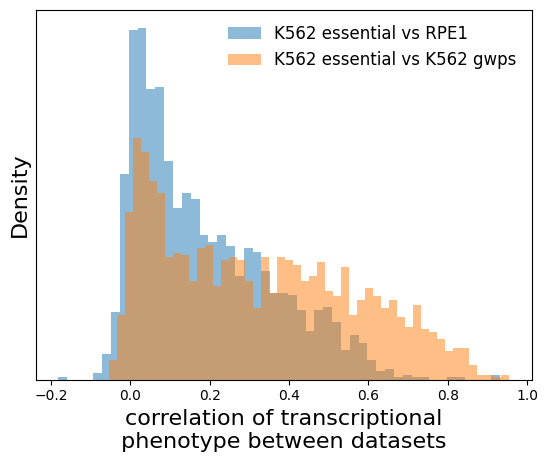

In [59]:
import matplotlib.pyplot as plt

plt.hist(corr, bins=50,alpha=0.5,density=True,label='K562 essential vs RPE1')
plt.hist(corr2, bins=50,alpha=0.5,density=True,label='K562 essential vs K562 gwps')
plt.xlabel("correlation of transcriptional\n phenotype between datasets ",fontsize=16)
plt.ylabel("Density",fontsize=16)
plt.yticks([])
plt.legend(fontsize=12,frameon=False)
#plt.title("Correlation distribution of known PPI pairs")
plt.show()

#### plot fig S4-DE (the KEGG enrichment of well/un-related perturbations)

In [60]:
well_cor_genes=corr[corr>0.5]
well_cor_genes=[extract_gene_name_from_index(i) for i in  well_cor_genes.index.to_list()]

un_cor_genes=corr[corr<0]
un_cor_genes=[extract_gene_name_from_index(i) for i in  un_cor_genes.index.to_list()]

In [62]:
import gseapy as gp
enr_well = gp.enrichr(
    gene_list=well_cor_genes,
    gene_sets='KEGG_2021_Human',
    organism='Human',
    outdir=None
)
top20_well = enr_well.results[enr_well.results['Adjusted P-value']<0.05].head(10)
top20_well['-log10(adjusted P)']=-np.log10(top20_well['Adjusted P-value'])


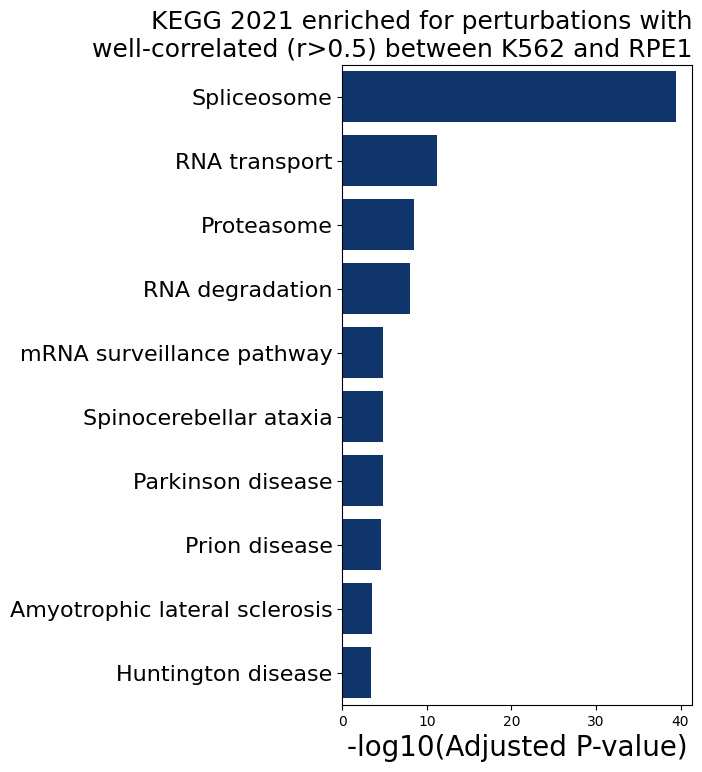

In [65]:

plt.figure(figsize=(10,8))
sns.barplot(
    data=top20_well,
    y='Term',
    x='-log10(adjusted P)',
    color="#00327D",
    dodge=True
)
plt.xlabel('-log10(Adjusted P-value)',fontsize=20)
plt.yticks(fontsize=16)  
plt.title('KEGG 2021 enriched for perturbations with\n well-correlated (r>0.5) between K562 and RPE1',
          fontsize=18,
          loc='right')
plt.tight_layout()
plt.ylabel('')
plt.subplots_adjust(left=0.6, right=0.95, top=0.9, bottom=0.1)  
plt.show()


In [67]:
import gseapy as gp
enr_un = gp.enrichr(
    gene_list=un_cor_genes,
    gene_sets='KEGG_2021_Human',
    organism='Human',
    outdir=None
)
top20_well = enr_un.results[enr_un.results['Adjusted P-value']<0.05].head(8)
top20_well['-log10(adjusted P)']=-np.log10(top20_well['Adjusted P-value'])


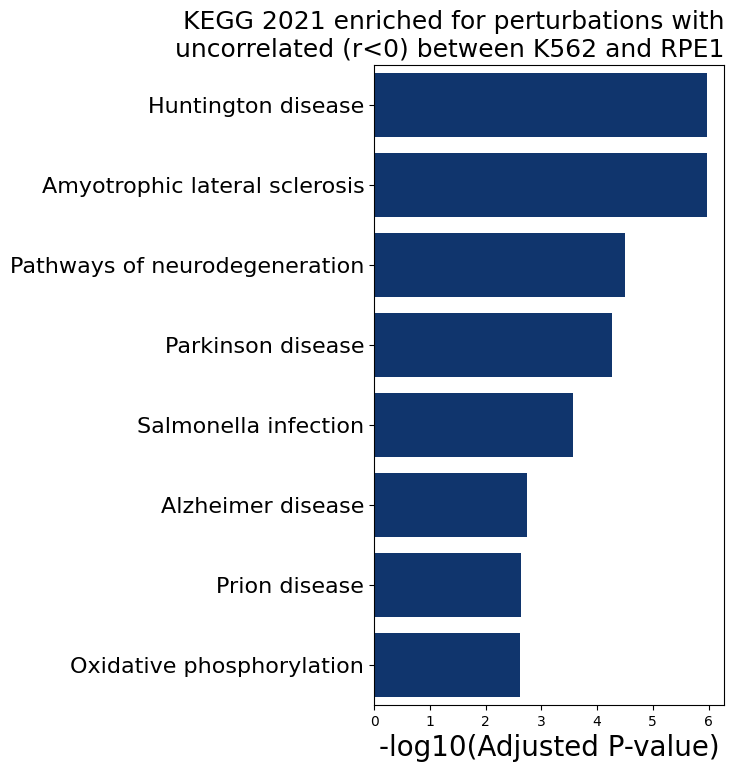

In [68]:

plt.figure(figsize=(10,8))
sns.barplot(
    data=top20_well,
    y='Term',
    x='-log10(adjusted P)',
    color="#00327D",
    dodge=True
)
plt.xlabel('-log10(Adjusted P-value)',fontsize=20)
plt.yticks(fontsize=16)  
plt.title('KEGG 2021 enriched for perturbations with\n uncorrelated (r<0) between K562 and RPE1',
          fontsize=18,
          loc='right')
plt.tight_layout()
plt.ylabel('')
plt.subplots_adjust(left=0.6, right=0.95, top=0.9, bottom=0.1)  
plt.show()


### plot fig S4-F Relationship between members of ribosomal subunits, biogenesis factors, and poorly characterized genes

In [69]:
ribo_genes=['BYSL',
            'C1orf131',
            'NOPCHAP1',
            'WDR36',
            'LTV1',
            'PDCD11',
            'RPS24',
            'RPS12',
            'RPS3',
            'NEPRO',
            'ZNF236',
            'UTP11',
            'RPL11',
            'RPL19',
            'ABCF1',
            'NIP7',
            'RRS1',
            'SDAD1',
            'CCDC86',
            'RPL24',
            'LAS1L',
            'SPATA5L1',
            'TMA16',
            'SPOUT1',
            'CINP']

In [70]:
ribo_adata=K562_ess_on_target[K562_ess_on_target.obs['target'].isin(ribo_genes)]

In [71]:
ribo_adata_df=ribo_adata.to_df()
ribo_adata_df.index=ribo_adata.obs['target']
ribo_adata_df.columns=ribo_adata.var['gene_name']

correlation_matrix_ribo = ribo_adata_df.T.corr(method='pearson')

Text(802.1527777777777, 0.5, '')

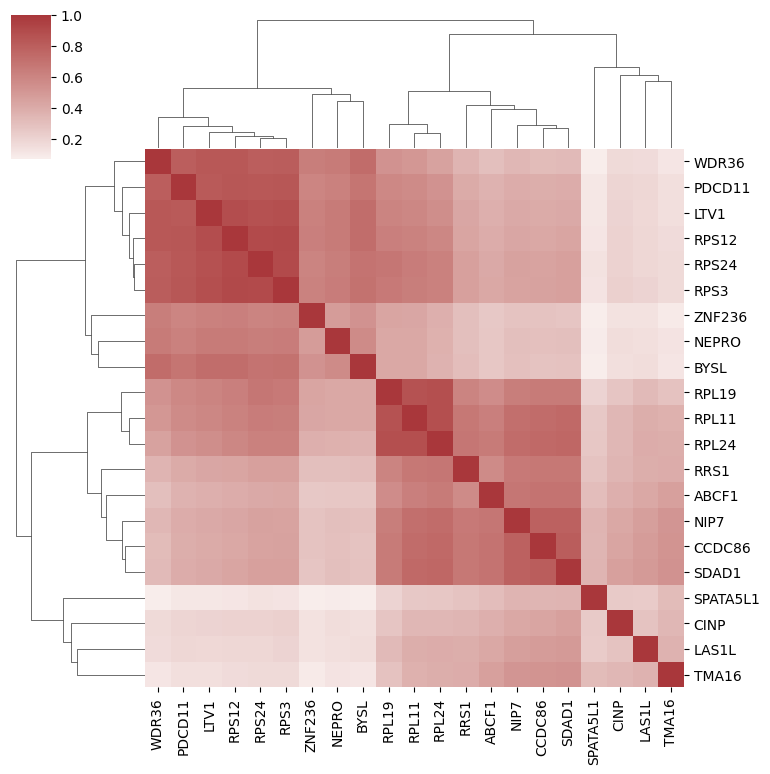

In [ ]:
cg=sns.clustermap(correlation_matrix_ribo,
                  #vmin=-0.5,
                  #vmax=0.5,
                  center=0,
                  cmap='vlag',figsize=(8,8),
                  #row_cluster=False,  
    #col_cluster=False   
    )
#cg.ax_heatmap.set_xticks([])
#cg.ax_heatmap.set_yticks([])
cg.ax_heatmap.set_xlabel('',fontsize=20)
cg.ax_heatmap.set_ylabel('',fontsize=20)

#cg.ax_heatmap.invert_xaxis()
#cg.ax_row_dendrogram.set_visible(False)
#cg.ax_col_dendrogram.set_visible(False)